# Progression

We identified several levers to improve our predictions:

1. **Add external data** $\rightarrow$ we added meteorological data, distances between airports, kerosene prices
2. **Adjust encoding** $\rightarrow$ we tried one-hot encoding and mean encoding
3. **Try different models** $\rightarrow$ we tried averaging various model before finding out that the best algorithm to deal with a large number of features was the random forest
4. **Tune hyperparameters** $\rightarrow$ we used gridsearch functions to find the best hyperparameters possible

We also tried other methods (among which: PCA, RF, correlation between the data using covariance matrix, spotting outliers, treating the data as time series, etc.), with less success.

1) pour les external data, je ne trouve pas la super donnée de corentin et Eva,  mais on peut peut être ajouter les jours fériés avec un encodage vrai/faux (1/0)

2) pour l'encoding, on pourrait essayer le maen encoding pour les données initiales (le tout premier set de data)

3) Pour le modèle j'ai entendu que beaucoup de gens utilisent le gradient boost. Je pense qu'on pourrait faire du model stacking avec gradient boost, random forest et aussi Adaboost
La méthode est par ex ici : https://medium.com/@pruchka/intro-to-model-stacking-in-python-70814e95d7a1

4) pour les hyperparameters et le overfit : il faudra faire une gridsearch pour les 3 sous modèles avant de les stacker, et utiliser la fonction crossvalidation pour éviter le overfit (pour gradient boost et adaboost)

# Data Exploration - Structure of the Dataset

### Main data

In [2]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns; sns.set()

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn.metrics import mean_squared_error

In [14]:
problem = imp.load_source('', 'problem.py') #import a module with different methods taken from ramp-workflow
X_df, y_array = problem.get_train_data() #get_train_data() is one of these methods

X_train = X_df.copy()
y_train = y_array.copy()

In [15]:
print(min(X_train['DateOfDeparture']))
print(max(X_train['DateOfDeparture']))

2011-09-01
2013-03-05


In [24]:
X_train['Arrival'].unique()

array(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA',
       'SEA', 'IAH'], dtype=object)

In [6]:
X_train.head()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
0,2012-06-19,ORD,DFW,12.875000,9.812647
1,2012-09-10,LAS,DEN,14.285714,9.466734
2,2012-10-05,DEN,LAX,10.863636,9.035883
3,2011-10-09,ATL,ORD,11.480000,7.990202
4,2012-02-21,DEN,SFO,11.450000,9.517159


In [7]:
X_train['Departure'].unique() #Return Index with unique values from an Index object

array(['ORD', 'LAS', 'DEN', 'ATL', 'SFO', 'EWR', 'IAH', 'LAX', 'DFW',
       'SEA', 'JFK', 'PHL', 'MIA', 'DTW', 'BOS', 'MSP', 'CLT', 'MCO',
       'PHX', 'LGA'], dtype=object)

In [8]:
X_train.describe()

,WeeksToDeparture,std_wtd
count,8902.000000,8902.000000
mean,11.446469,8.617773
std,2.787140,2.139604
min,2.625000,2.160247
25%,9.523810,7.089538
50%,11.300000,8.571116
75%,13.240000,10.140521
max,23.163265,15.862216


In [9]:
X_train.shape

(8902, 5)

In [10]:
X_train.dtypes

DateOfDeparture      object
Departure            object
Arrival              object
WeeksToDeparture    float64
std_wtd             float64
dtype: object

In [11]:
pd.DataFrame(data=X_train.isna().sum(), columns=["Number of NAs"]).transpose()

,DateOfDeparture,Departure,Arrival,WeeksToDeparture,std_wtd
Number of NAs,0,0,0,0,0


$\rightarrow$ There are no missing values

In [12]:
#Check Skew Variables
X_train.skew()

WeeksToDeparture    0.270212
std_wtd             0.066525
dtype: float64

$\rightarrow$ Little skew so ok

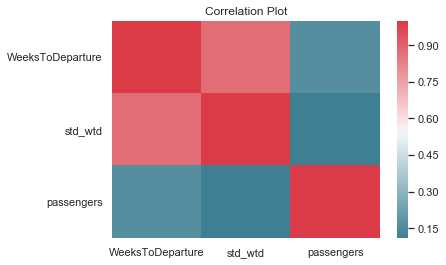

In [13]:
X_all=X_train.copy()
X_all["passengers"] = y_array

cor = X_all.corr(method='pearson')
sns.heatmap(cor, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Plot")
plt.show()

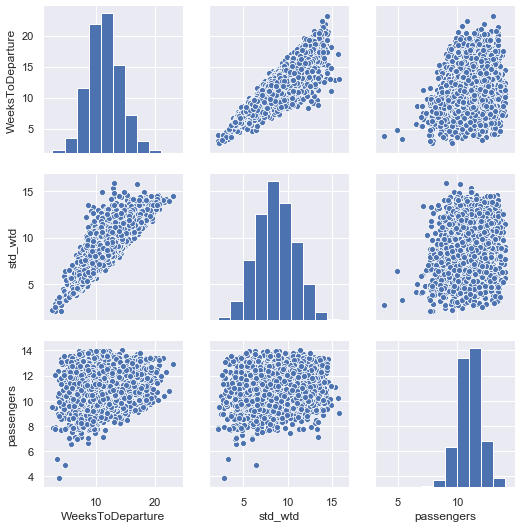

In [14]:
sns.pairplot(X_all)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d362f28>]],
      dtype=object)

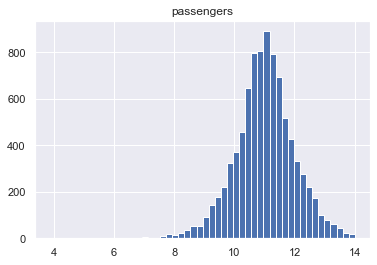

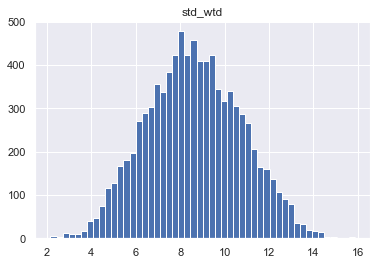

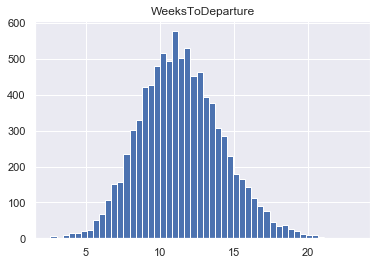

In [15]:
plt.hist(y_array, bins=50)
plt.title("passengers")
X_train.hist('std_wtd', bins=50)
X_train.hist('WeeksToDeparture', bins=50)

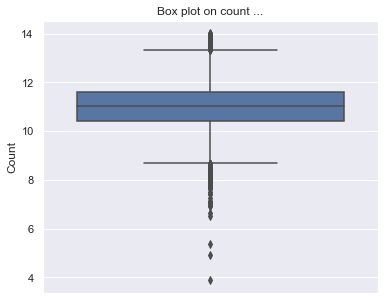

In [16]:
fig, ax = plt.subplots(figsize = (6,5))
sns.boxplot(data=X_train, y= y_array, orient="v")
ax.set(ylabel='Count', title="Box plot on count ...")
plt.show()

In [17]:
# Should we remove the outliers ?

print(min(X_all['passengers']))
sorted_X_all = sorted(X_all['passengers'])
sorted_y_array[0:3]

# If we want to remove these 3 outliers we have to find and remove the corresponding lines
# Should we do it in the data encoder ?

3.8781080598300006


NameError: name 'sorted_y_array' is not defined

# Add external data

### Jet fuel prices

In [19]:
fuel = pd.read_csv('data/Jet Fuel Prices.csv', sep=';')
fuel = fuel.drop('Unnamed: 2', axis = 1)
fuel.head()
fuel.to_csv('fuelprices.csv')

### Meteorological data

In [107]:
external = pd.read_csv('data/external_data2.csv')
external.head()

,Unnamed: 0,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees,Rank_2018,Airports (large hubs),Major city served,State,2018,2017,2016,2015,city,city_ascii,state_id,state_name,county_fips,county_name,county_fips_all,county_name_all,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
1,1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
2,2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
3,3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09
4,4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149,1,Hartsfield–Jackson Atlanta International Airport,Atlanta,GA,51866464,50251964,50501858,49340732,Atlanta,Atlanta,GA,Georgia,13121.0,Fulton,13121|13089|13067,Fulton|DeKalb|Cobb,33.7627,-84.4225,5228750.0,1384.0,polygon,False,True,America/New_York,1.0,30334 30331 30332 30309 30308 30305 30307 3030...,1.840016e+09


In [ ]:
X_train=X_train.drop(['Airports (large hubs)_Dep', 'Airports (large hubs)_Arr'], axis=1)

In [ ]:
X_train = X_train.join(us_cities_dep, how='left', on='Major city served_Dep')
X_train = X_train.join(us_cities_arr, how='left', on='Major city served_Arr')

### Distances between cities

In [106]:
distances = pd.read_csv('data/uscities.csv')
distances = distances[['city', 'lat', 'lng']]
distances.head()

,city,lat,lng
0,South Creek,46.9994,-122.3921
1,Roslyn,47.2507,-121.0989
2,Sprague,47.3048,-117.9713
3,Gig Harbor,47.3352,-122.5968
4,Lake Cassidy,48.0639,-122.0920


In [101]:
# Method 1 to find distances between lat/lng coordinates

from geopy.distance import distance

coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)

print(distance(coords_1, coords_2).km)

279.35290160430094


In [109]:
# Method 2 to find distances between lat/lng coordinates

from pyproj import Geod

wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

#Get distance between pairs of lat-lon points
def distance(lat1,lon1,lat2,lon2):
  az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) #Yes, this order is correct
  return dist

#Add/update a column to the data frame with the distances (in metres)
df['dist'] = Distance(df['lat1'].tolist(),df['lon1'].tolist(),df['lat2'].tolist(),df['lon2'].tolist())
df.head()

,lat1,lon1,lat2,lon2,dist
0,-10.114358,8.573721,-38.991548,-61.552866,7.594303e+06
1,35.933216,171.032941,89.034981,82.622334,6.021504e+06
2,20.346283,153.702641,68.865326,-111.730968,8.092834e+06
3,-20.624550,-122.104338,-14.878606,93.134811,1.451769e+07
4,-10.873872,-109.487515,65.325863,-164.032859,9.567952e+06


In [ ]:
# We need to add the coordinates of both departure and arrival in the main dataset to calculate distances.

### Average prices

In [62]:
prices = pd.read_csv("/Users/Thomas/Downloads/Consumer_Airfare_Report__Table_1_-_Top_1_000_Contiguous_State_City-Pair_Markets.csv")
prices.head()

,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,nsmiles,passengers,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,table_1_flag,Geocoded_City1,Geocoded_City2
0,2012,4,30994,31453,"Charleston, SC","Houston, TX",928,161,242.19,WN,0.39,221.00,WN,0.39,221.00,1,"Charleston, SC\n(32.77647, -79.931027)","Houston, TX\n(29.760803, -95.369506)"
1,2011,4,33044,33195,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63,WN,0.66,173.66,DL,0.21,166.94,1,"Louisville, KY\n(38.256078, -85.751569)","Tampa, FL (Metropolitan Area)\n(37.8606, -78.8..."
2,2013,2,31650,33570,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01,DL,0.46,279.09,SY,0.22,189.26,1,"Minneapolis/St. Paul, MN\n(44.977479, -93.264346)","San Diego, CA\n(32.71576, -117.163817)"
3,2013,2,31703,33667,"New York City, NY (Metropolitan Area)","Norfolk, VA (Metropolitan Area)",337,397,241.83,DL,0.39,257.12,US,0.25,208.27,1,"New York City, NY (Metropolitan Area)\n(40.123...","Norfolk, VA (Metropolitan Area)\n(36.846164, -..."
4,2012,2,30977,30852,"Chicago, IL","Washington, DC (Metropolitan Area)",622,5160,219.09,UA,0.45,228.31,WN,0.28,202.25,1,"Chicago, IL\n(41.775002, -87.696388)","Washington, DC (Metropolitan Area)\n(38.892062..."


In [63]:
prices.drop(prices.columns[[2, 3, 9, 10, 11, 12, 13, 14]], axis=1, inplace = True)

In [64]:
prices.drop(prices.columns[[7,8,9]], axis=1, inplace = True)

In [65]:
prices.head()

,Year,quarter,city1,city2,nsmiles,passengers,fare
0,2012,4,"Charleston, SC","Houston, TX",928,161,242.19
1,2011,4,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63
2,2013,2,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01
3,2013,2,"New York City, NY (Metropolitan Area)","Norfolk, VA (Metropolitan Area)",337,397,241.83
4,2012,2,"Chicago, IL","Washington, DC (Metropolitan Area)",622,5160,219.09


In [66]:
prices.rename({"city1": "Departure", "city2": "Arrival", "nsmiles": "miles_distance", "passengers": "daily_passengers", "fare":"average_fare"}, axis=1, inplace=True)
prices.head()

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare
0,2012,4,"Charleston, SC","Houston, TX",928,161,242.19
1,2011,4,"Louisville, KY","Tampa, FL (Metropolitan Area)",727,294,174.63
2,2013,2,"Minneapolis/St. Paul, MN","San Diego, CA",1532,700,244.01
3,2013,2,"New York City, NY (Metropolitan Area)","Norfolk, VA (Metropolitan Area)",337,397,241.83
4,2012,2,"Chicago, IL","Washington, DC (Metropolitan Area)",622,5160,219.09


In [67]:
prices.astype({"Departure": str, "Arrival": str})
prices.dtypes

Year                  int64
quarter               int64
Departure            object
Arrival              object
miles_distance        int64
daily_passengers      int64
average_fare        float64
dtype: object

In [68]:
prices.sort_values(by=['Year','quarter','Departure','Arrival'], inplace=True)
prices.head()

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare
5290,2011,1,"Albany, NY","Chicago, IL",723,213,211.59
2233,2011,1,"Albany, NY","Fort Myers, FL",1204,151,229.19
3349,2011,1,"Albany, NY","Las Vegas, NV",2237,220,231.51
8344,2011,1,"Albany, NY","Miami, FL (Metropolitan Area)",1225,368,200.10
2452,2011,1,"Albany, NY","Orlando, FL",1073,624,188.21


In [69]:
prices.reset_index(drop=True, inplace=True)
prices.head()

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare
0,2011,1,"Albany, NY","Chicago, IL",723,213,211.59
1,2011,1,"Albany, NY","Fort Myers, FL",1204,151,229.19
2,2011,1,"Albany, NY","Las Vegas, NV",2237,220,231.51
3,2011,1,"Albany, NY","Miami, FL (Metropolitan Area)",1225,368,200.10
4,2011,1,"Albany, NY","Orlando, FL",1073,624,188.21


In [71]:
prices.to_csv('av_fares_pass.csv')

Merge with external data

# Data cleaning and preprocessing

In [117]:
X_train = X_df.copy()
y_train = y_array.copy()

In [119]:
import os

def transform(X_df):
    X_encoded = X_df.copy()

    __file__ = 'submissions/starting_kit/'
    path = os.path.dirname(__file__)
    data_weather = pd.read_csv(os.path.join(path, 'external_data.csv'))
    X_weather = data_weather[['Date', 'AirPort', 'Max TemperatureC']]
    X_weather = X_weather.rename(
        columns={'Date': 'DateOfDeparture', 'AirPort': 'Arrival'})

    #External data
    X_encoded = pd.merge(
        X_encoded, X_weather, how='left',
        left_on=['DateOfDeparture', 'Arrival'],
        right_on=['DateOfDeparture', 'Arrival'],
        sort=False)
    
    #Dummy Depart/Arr
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Departure'], prefix='d'))
    X_encoded = X_encoded.join(
        pd.get_dummies(X_encoded['Arrival'], prefix='a'))
    
    #IATA Data
    iata = pd.read_csv('data/IATA_US_CODES.csv')
    iata['2018']=iata['2018'].str.replace(',','')
    iata['2017']=iata['2017'].str.replace(',','')
    iata['2016']=iata['2016'].str.replace(',','')
    iata['2015']=iata['2015'].str.replace(',','')
    iata['2018']=iata['2018'].str.replace('\xa0','')
    iata['2017']=iata['2017'].str.replace('\xa0','')
    iata['2016']=iata['2016'].str.replace('\xa0','')
    iata['2015']=iata['2015'].str.replace('\xa0','')
    iata['2018'] = iata['2018'].astype(int)
    iata['2017'] = iata['2017'].astype(int)
    iata['2016'] = iata['2016'].astype(int)
    iata['2015'] = iata['2015'].astype(int)
    iata['IATA Code']=iata['IATA Code'].astype(str)
    iata['IATA Code']=iata['IATA Code'].str.rstrip()
    iata=iata.set_index('IATA Code')
    iata_dep=iata.add_suffix('_Dep')
    iata_arr=iata.add_suffix('_Arr')
    
    X_encoded=X_encoded.join(iata_dep, on='Departure', how='left')
    X_encoded=X_encoded.join(iata_arr, on='Arrival', how='left')
   
    #Dummy Iata Dep/Arr
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['State_Dep'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['State_Arr'], prefix='a'))
    
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Major city served_Dep'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(
        X_encoded['Major city served_Arr'], prefix='a'))
    X_encoded=X_encoded.drop(['Airports (large hubs)_Dep', 'Airports (large hubs)_Arr','Major city served_Arr','Major city served_Dep','State_Arr','State_Dep'], axis=1)

    
    
    #Dummy Date
    X_encoded['Weekend'] = ((pd.DatetimeIndex(X_encoded['DateOfDeparture']).dayofweek) // 5 == 1).astype(float)
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['DateOfDeparture'] = pd.to_datetime(X_encoded['DateOfDeparture'])
    X_encoded['year'] = X_encoded['DateOfDeparture'].dt.year
    X_encoded['month'] = X_encoded['DateOfDeparture'].dt.month
    X_encoded['day'] = X_encoded['DateOfDeparture'].dt.day
    X_encoded['weekday'] = X_encoded['DateOfDeparture'].dt.weekday
    X_encoded['week'] = X_encoded['DateOfDeparture'].dt.week
    X_encoded['n_days'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("1970-01-01")).days)

    #We one hot encode all those
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['year'], prefix='y'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['day'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['weekday'], prefix='wd'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['week'], prefix='w'))
    X_encoded = X_encoded.drop('DateOfDeparture', axis=1)
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)
    
    
    
    return X_encoded



In [120]:
X_train = transform(X_train)
X_train.head()

,WeeksToDeparture,std_wtd,Max TemperatureC,d_ATL,d_BOS,d_CLT,d_DEN,d_DFW,d_DTW,d_EWR,d_IAH,d_JFK,d_LAS,d_LAX,d_LGA,d_MCO,d_MIA,d_MSP,d_ORD,d_PHL,d_PHX,d_SEA,d_SFO,a_ATL,a_BOS,a_CLT,a_DEN,a_DFW,a_DTW,a_EWR,a_IAH,a_JFK,a_LAS,a_LAX,a_LGA,a_MCO,a_MIA,a_MSP,a_ORD,a_PHL,a_PHX,a_SEA,a_SFO,Rank_2018_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,Rank_2018_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,d_AZ,d_CA,d_CO,d_FL,d_GA,d_IL,d_MA,d_MI,d_MN,d_NC,d_NJ,d_NV,d_NY,d_PA,d_TX,d_WA,a_AZ,a_CA,a_CO,a_FL,a_GA,a_IL,a_MA,a_MI,a_MN,a_NC,a_NJ,a_NV,a_NY,a_PA,a_TX,a_WA,d_Atlanta,d_Boston,d_Charlotte,d_Chicago,d_Dallas/Fort Worth,d_Denver,d_Detroit,d_Houston,d_Las Vegas,d_Los Angeles,d_Miami,d_Minneapolis/St. Paul,d_New York,d_New York/Newark,d_Orlando,d_Philadelphia,d_Phoenix,d_San Francisco,d_Seattle/Tacoma,a_Atlanta,a_Boston,a_Charlotte,a_Chicago,a_Dallas/Fort Worth,a_Denver,a_Detroit,a_Houston,a_Las Vegas,a_Los Angeles,a_Miami,a_Minneapolis/St. Paul,a_New York,a_New York/Newark,a_Orlando,a_Philadelphia,a_Phoenix,a_San Francisco,a_Seattle/Tacoma,Weekend,year,month,day,weekday,week,n_days,y_2011,y_2012,y_2013,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,wd_0,wd_1,wd_2,wd_3,wd_4,wd_5,wd_6,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,w_40,w_41,w_42,w_43,w_44,w_45,w_46,w_47,w_48,w_49,w_50,w_51,w_52
0,12.875000,9.812647,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,39874879,38593028,37589899,36305668,4,32800721,31816933,31283579,31589832,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2012,6,19,1,25,15510,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,14.285714,9.466734,33,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,23655285,23364393,22833267,21824231,5,31363573,29809097,28267394,26280043,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,2012,9,10,0,37,15593,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10.863636,9.035883,22,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,31363573,29809097,28267394,26280043,2,42626783,41232432,39636042,36351226,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,2012,10,5,4,40,15618,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,11.480000,7.990202,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,51866464,50251964,50501858,49340732,3,39874879,38593028,37589899,36305668,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,2011,10,9,6,40,15256,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,11.450000,9.517159,16,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,31363573,29809097,28267394,26280043,7,27794154,26900048,25707101,24190549,0,0,1,0,0,0,0,0,0,0,0,

## Train the model

In [121]:
clf = RandomForestRegressor(
            n_estimators=600, max_depth=110, max_features='sqrt',
             min_samples_split=10, min_samples_leaf=1, bootstrap=True)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=110,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=600,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [122]:
y_pred_train = clf.predict(X_train)
score_type = problem.score_types[0]
print("train rmse: ", score_type(y_train, y_pred_train))

train rmse:  0.3051832505231993


In [124]:
X_test_df, y_test_array = problem.get_test_data()
X_test = transform(X_test_df)

In [125]:
y_pred = clf.predict(X_test)
score_type = problem.score_types[0]
print("test rmse: ", score_type(y_test_array, y_pred))

test rmse:  0.48016699668934665


In [129]:
X_train = transform(X_df)
y_train = y_array.copy()

X_test_df, y_test_array = problem.get_test_data()
X_test_df=transform(X_test_df)

In [130]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [131]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/anaconda3/envs/air_passengers/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

## Work on external data

In [7]:
external = pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/external_data.csv')
external

,Date,AirPort,Max TemperatureC,Mean TemperatureC,Min TemperatureC,Dew PointC,MeanDew PointC,Min DewpointC,Max Humidity,Mean Humidity,Min Humidity,Max Sea Level PressurehPa,Mean Sea Level PressurehPa,Min Sea Level PressurehPa,Max VisibilityKm,Mean VisibilityKm,Min VisibilitykM,Max Wind SpeedKm/h,Mean Wind SpeedKm/h,Max Gust SpeedKm/h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2011-09-01,ATL,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,0.00,3,NaN,129
1,2011-09-02,ATL,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,0.00,2,NaN,185
2,2011-09-03,ATL,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,0.00,4,NaN,147
3,2011-09-04,ATL,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,6.10,6,Rain,139
4,2011-09-05,ATL,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,16.00,8,Rain-Thunderstorm,149
5,2011-09-06,ATL,24,19,14,22,15,13,90,87,84,1011,1006,998,16,12,4,47,18,56.0,1.52,8,Rain,212
6,2011-09-07,ATL,21,18,14,14,14,13,93,81,68,1016,1014,1011,16,13,2,23,13,32.0,T,8,NaN,297
7,2011-09-08,ATL,23,19,14,14,13,12,87,70,53,1015,1014,1013,16,16,16,27,15,32.0,0.00,5,NaN,322
8,2011-09-09,ATL,27,21,14,13,12,11,93,65,36,1015,1014,1013,16,16,16,26,11,35.0,0.00,1,NaN,302
9,2011-09-10,ATL,29,22,14,13,11,7,84,56,28,1019,1016,1015,16,16,16,21,9,32.0,0.00,0,NaN,321


In [8]:
external.shape

(11040, 24)

In [21]:
print(external['AirPort'].unique())
print(len(external['AirPort'].unique()))
len(external['Date'].unique())

['ATL' 'ORD' 'LAX' 'DFW' 'DEN' 'JFK' 'SFO' 'CLT' 'LAS' 'PHX' 'IAH' 'MIA'
 'MCO' 'EWR' 'SEA' 'MSP' 'DTW' 'PHL' 'BOS' 'LGA']
20


552

In [27]:
fares = pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/av_fares_pass.csv')

In [31]:
fares.drop('Unnamed: 0', axis=1, inplace=True)


KeyError: "['Unnamed: 0'] not found in axis"

In [32]:
fares.head()

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare
0,2011,1,"Albany, NY","Chicago, IL",723,213,211.59
1,2011,1,"Albany, NY","Fort Myers, FL",1204,151,229.19
2,2011,1,"Albany, NY","Las Vegas, NV",2237,220,231.51
3,2011,1,"Albany, NY","Miami, FL (Metropolitan Area)",1225,368,200.10
4,2011,1,"Albany, NY","Orlando, FL",1073,624,188.21


In [33]:
fares['Departure'].unique()

array(['Albany, NY', 'Albuquerque, NM', 'Allentown/Bethlehem/Easton, PA',
       'Amarillo, TX', 'Aspen, CO', 'Atlanta, GA (Metropolitan Area)',
       'Atlantic City, NJ', 'Austin, TX', 'Baton Rouge, LA',
       'Bellingham, WA', 'Billings, MT', 'Birmingham, AL',
       'Bloomington/Normal, IL', 'Boise, ID',
       'Boston, MA (Metropolitan Area)', 'Buffalo, NY', 'Burlington, VT',
       'Cedar Rapids/Iowa City, IA', 'Charleston, SC', 'Charlotte, NC',
       'Chicago, IL', 'Cincinnati, OH',
       'Cleveland, OH (Metropolitan Area)', 'Colorado Springs, CO',
       'Columbia, SC', 'Columbus, OH', 'Corpus Christi, TX',
       'Dallas/Fort Worth, TX', 'Dayton, OH', 'Denver, CO',
       'Des Moines, IA', 'Detroit, MI', 'Eagle, CO', 'El Paso, TX',
       'Eugene, OR', 'Fargo, ND', 'Fayetteville, AR', 'Flint, MI',
       'Fort Myers, FL', 'Fresno, CA', 'Grand Rapids, MI',
       'Greensboro/High Point, NC', 'Greenville/Spartanburg, SC',
       'Harlingen/San Benito, TX', 'Harrisburg, PA', '

In [36]:
fares2 = fares.loc[fares['Departure'].isin(['Dallas/Fort Worth, TX', 'Denver, CO', 'Los Angeles, CA (Metropolitan Area)',
                                  'Chicago, IL', 'San Francisco, CA (Metropolitan Area)',
                                  'Orlando, FL', 'Las Vegas, NV', 'Charlotte, NC', 'Minneapolis/St. Paul, MN',
                                  'Phoenix, AZ', 'Detroit, MI', 'Miami, FL (Metropolitan Area)',
                                  'Boston, MA (Metropolitan Area)', 'Philadelphia, PA', 'New York City, NY (Metropolitan Area)',
                                  'Atlanta, GA (Metropolitan Area)', 'Seattle, WA', 'Houston, TX'])]

In [37]:
fares3 = fares2.loc[fares['Arrival'].isin(['Dallas/Fort Worth, TX', 'Denver, CO', 'Los Angeles, CA (Metropolitan Area)',
                                  'Chicago, IL', 'San Francisco, CA (Metropolitan Area)',
                                  'Orlando, FL', 'Las Vegas, NV', 'Charlotte, NC', 'Minneapolis/St. Paul, MN',
                                  'Phoenix, AZ', 'Detroit, MI', 'Miami, FL (Metropolitan Area)',
                                  'Boston, MA (Metropolitan Area)', 'Philadelphia, PA', 'New York City, NY (Metropolitan Area)',
                                  'Atlanta, GA (Metropolitan Area)', 'Seattle, WA', 'Houston, TX'])]

In [38]:
fares3

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare
32,2011,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1671,215.75
34,2011,1,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",227,392,151.95
35,2011,1,"Atlanta, GA (Metropolitan Area)","Chicago, IL",606,2302,173.68
39,2011,1,"Atlanta, GA (Metropolitan Area)","Dallas/Fort Worth, TX",732,2128,200.90
41,2011,1,"Atlanta, GA (Metropolitan Area)","Denver, CO",1199,1313,182.59
42,2011,1,"Atlanta, GA (Metropolitan Area)","Detroit, MI",594,976,188.72
47,2011,1,"Atlanta, GA (Metropolitan Area)","Houston, TX",696,1252,207.95
51,2011,1,"Atlanta, GA (Metropolitan Area)","Las Vegas, NV",1747,1380,228.25
52,2011,1,"Atlanta, GA (Metropolitan Area)","Los Angeles, CA (Metropolitan Area)",1946,2331,242.78
55,2011,1,"Atlanta, GA (Metropolitan Area)","Miami, FL (Metropolitan Area)",595,3051,133.57


In [39]:
fares3.shape

(1824, 7)

In [45]:
fares3.sort_values(by=['Departure','Arrival','Year','quarter'], inplace=True)
fares3.reset_index(drop=True, inplace=True)

/Users/Thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
fares3.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/fares&co.csv')

In [ ]:
'DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA',
       'SEA', 'IAH'

In [47]:
air = pd.read_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/air_times.csv')
air.head()

,Unnamed: 0,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,AIR_TIME_MEAN
0,0,04A,"Lik, AK",OTZ,"Kotzebue, AK",192.0
1,1,04A,"Lik, AK",WTK,"Noatak, AK",46.0
2,2,05A,"Little Squaw, AK",FAI,"Fairbanks, AK",67.4
3,3,06A,"Kizhuyak, AK",ADQ,"Kodiak, AK",19.5
4,4,08A,"Elizabeth Island, AK",KEB,"Nanwalek, AK",8.0


In [48]:
air.drop('Unnamed: 0', axis=1, inplace=True)

In [49]:
air2 = air.loc[air['ORIGIN'].isin(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA', 'SEA', 'IAH'])]

In [50]:
air3 = air2.loc[air['DEST'].isin(['DFW', 'DEN', 'LAX', 'ORD', 'SFO', 'MCO', 'LAS', 'CLT', 'MSP',
       'EWR', 'PHX', 'DTW', 'MIA', 'BOS', 'PHL', 'JFK', 'ATL', 'LGA', 'SEA', 'IAH'])]

In [51]:
air3.sort_values(by=['ORIGIN','DEST'], inplace=True)
air3.reset_index(drop=True, inplace=True)

/Users/Thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
air3.head()

,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,AIR_TIME_MEAN
0,ATL,"Atlanta, GA",ATL,"Atlanta, GA",45.00
1,ATL,"Atlanta, GA",BOS,"Boston, MA",6002.21
2,ATL,"Atlanta, GA",CLT,"Charlotte, NC",1481.41
3,ATL,"Atlanta, GA",DEN,"Denver, CO",7305.19
4,ATL,"Atlanta, GA",DFW,"Dallas/Fort Worth, TX",8133.17


In [53]:
air3.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/airtimes.csv')

In [54]:
len(air3['DEST'].unique())

20

In [58]:
Names_Met = {'Dallas/Fort Worth, TX':'DFW', 'Denver, CO':'DEN', 'Los Angeles, CA (Metropolitan Area)':'LAX',
             'Chicago, IL':'ORD', 'San Francisco, CA (Metropolitan Area)':'SFO', 'Orlando, FL':'MCO',
             'Las Vegas, NV':'LAS', 'Charlotte, NC':'CLT', 'Minneapolis/St. Paul, MN':'MSP',
             'Phoenix, AZ':'PHX', 'Detroit, MI':'DTW',
             'Miami, FL (Metropolitan Area)':'MIA', 'Boston, MA (Metropolitan Area)':'BOS', 
             'Philadelphia, PA':'PHL', 'New York City, NY (Metropolitan Area)':'JFK', 
             'Atlanta, GA (Metropolitan Area)':'ATL',
             'Seattle, WA':'SEA', 'Houston, TX':'IAH'}

In [ ]:
'New York City, NY (Metropolitan Area)':'LGA'
    'New York City, NY (Metropolitan Area)':'EWR'

In [59]:
print(Names_Met)

{'Dallas/Fort Worth, TX': 'DFW', 'Denver, CO': 'DEN', 'Los Angeles, CA (Metropolitan Area)': 'LAX', 'Chicago, IL': 'ORD', 'San Francisco, CA (Metropolitan Area)': 'SFO', 'Orlando, FL': 'MCO', 'Las Vegas, NV': 'LAS', 'Charlotte, NC': 'CLT', 'Minneapolis/St. Paul, MN': 'MSP', 'Phoenix, AZ': 'PHX', 'Detroit, MI': 'DTW', 'Miami, FL (Metropolitan Area)': 'MIA', 'Boston, MA (Metropolitan Area)': 'BOS', 'Philadelphia, PA': 'PHL', 'New York City, NY (Metropolitan Area)': 'JFK', 'Atlanta, GA (Metropolitan Area)': 'ATL', 'Seattle, WA': 'SEA', 'Houston, TX': 'IAH'}


In [63]:
fares3['ARR'] = fares3['Arrival'].map(Names_Met)

/Users/Thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
fares3

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1671,215.75,ATL,BOS
1,2011,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2295,218.02,ATL,BOS
2,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
3,2011,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2117,227.89,ATL,BOS
4,2012,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1704,235.04,ATL,BOS
5,2012,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,226.73,ATL,BOS
6,2012,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2437,196.87,ATL,BOS
7,2012,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2255,203.29,ATL,BOS
8,2013,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1784,212.29,ATL,BOS
9,2013,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2477,216.50,ATL,BOS


In [66]:
fares3.sort_values(by=['Year','quarter'], inplace=True)
fares3.reset_index(drop=True, inplace=True)
fares3

/Users/Thomas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1671,215.75,ATL,BOS
1,2011,1,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",227,392,151.95,ATL,CLT
2,2011,1,"Atlanta, GA (Metropolitan Area)","Chicago, IL",606,2302,173.68,ATL,ORD
3,2011,1,"Atlanta, GA (Metropolitan Area)","Dallas/Fort Worth, TX",732,2128,200.90,ATL,DFW
4,2011,1,"Atlanta, GA (Metropolitan Area)","Denver, CO",1199,1313,182.59,ATL,DEN
5,2011,1,"Atlanta, GA (Metropolitan Area)","Detroit, MI",594,976,188.72,ATL,DTW
6,2011,1,"Atlanta, GA (Metropolitan Area)","Houston, TX",696,1252,207.95,ATL,IAH
7,2011,1,"Atlanta, GA (Metropolitan Area)","Las Vegas, NV",1747,1380,228.25,ATL,LAS
8,2011,1,"Atlanta, GA (Metropolitan Area)","Los Angeles, CA (Metropolitan Area)",1946,2331,242.78,ATL,LAX
9,2011,1,"Atlanta, GA (Metropolitan Area)","Miami, FL (Metropolitan Area)",595,3051,133.57,ATL,MIA


In [68]:
fares4 = fares3.drop(fares3[(fares3['Year'] == 2011) & (fares3['quarter'] == 1)].index)
fares4

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
152,2011,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2295,218.02,ATL,BOS
153,2011,2,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",227,430,170.70,ATL,CLT
154,2011,2,"Atlanta, GA (Metropolitan Area)","Chicago, IL",606,3069,176.93,ATL,ORD
155,2011,2,"Atlanta, GA (Metropolitan Area)","Dallas/Fort Worth, TX",732,2378,203.29,ATL,DFW
156,2011,2,"Atlanta, GA (Metropolitan Area)","Denver, CO",1199,1465,202.09,ATL,DEN
157,2011,2,"Atlanta, GA (Metropolitan Area)","Detroit, MI",594,1287,192.49,ATL,DTW
158,2011,2,"Atlanta, GA (Metropolitan Area)","Houston, TX",696,1503,214.60,ATL,IAH
159,2011,2,"Atlanta, GA (Metropolitan Area)","Las Vegas, NV",1747,1455,237.43,ATL,LAS
160,2011,2,"Atlanta, GA (Metropolitan Area)","Los Angeles, CA (Metropolitan Area)",1946,2993,237.91,ATL,LAX
161,2011,2,"Atlanta, GA (Metropolitan Area)","Miami, FL (Metropolitan Area)",595,3517,144.87,ATL,MIA


In [70]:
fares5 = fares4.drop(fares4[(fares4['Year'] == 2011) & (fares4['quarter'] == 2)].index)
fares5

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
304,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
305,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
306,2011,3,"Atlanta, GA (Metropolitan Area)","Chicago, IL",606,3080,170.34,ATL,ORD
307,2011,3,"Atlanta, GA (Metropolitan Area)","Dallas/Fort Worth, TX",731,2246,197.85,ATL,DFW
308,2011,3,"Atlanta, GA (Metropolitan Area)","Denver, CO",1199,1555,175.94,ATL,DEN
309,2011,3,"Atlanta, GA (Metropolitan Area)","Detroit, MI",594,1252,184.39,ATL,DTW
310,2011,3,"Atlanta, GA (Metropolitan Area)","Houston, TX",696,1373,203.41,ATL,IAH
311,2011,3,"Atlanta, GA (Metropolitan Area)","Las Vegas, NV",1747,1274,230.24,ATL,LAS
312,2011,3,"Atlanta, GA (Metropolitan Area)","Los Angeles, CA (Metropolitan Area)",1946,2761,250.10,ATL,LAX
313,2011,3,"Atlanta, GA (Metropolitan Area)","Miami, FL (Metropolitan Area)",594,3115,125.48,ATL,MIA


In [73]:
fares6 = fares5.drop(fares5[(fares5['Year'] == 2013) & (fares5['quarter'] == 2)].index)
fares6

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
304,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
305,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
306,2011,3,"Atlanta, GA (Metropolitan Area)","Chicago, IL",606,3080,170.34,ATL,ORD
307,2011,3,"Atlanta, GA (Metropolitan Area)","Dallas/Fort Worth, TX",731,2246,197.85,ATL,DFW
308,2011,3,"Atlanta, GA (Metropolitan Area)","Denver, CO",1199,1555,175.94,ATL,DEN
309,2011,3,"Atlanta, GA (Metropolitan Area)","Detroit, MI",594,1252,184.39,ATL,DTW
310,2011,3,"Atlanta, GA (Metropolitan Area)","Houston, TX",696,1373,203.41,ATL,IAH
311,2011,3,"Atlanta, GA (Metropolitan Area)","Las Vegas, NV",1747,1274,230.24,ATL,LAS
312,2011,3,"Atlanta, GA (Metropolitan Area)","Los Angeles, CA (Metropolitan Area)",1946,2761,250.10,ATL,LAX
313,2011,3,"Atlanta, GA (Metropolitan Area)","Miami, FL (Metropolitan Area)",594,3115,125.48,ATL,MIA


In [76]:
fares6 = fares6.drop(fares6[(fares6['Year'] == 2013) & (fares6['quarter'] == 3)].index)
fares6

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
1,2011,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2117,227.89,ATL,BOS
2,2012,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1704,235.04,ATL,BOS
3,2012,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,226.73,ATL,BOS
4,2012,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2437,196.87,ATL,BOS
5,2012,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2255,203.29,ATL,BOS
6,2013,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1784,212.29,ATL,BOS
7,2013,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2477,216.50,ATL,BOS
9,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
10,2011,4,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,370,165.83,ATL,CLT


In [77]:
fares6 = fares6.drop(fares6[(fares6['Year'] == 2013) & (fares6['quarter'] == 4)].index)
fares6

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
1,2011,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2117,227.89,ATL,BOS
2,2012,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1704,235.04,ATL,BOS
3,2012,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,226.73,ATL,BOS
4,2012,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2437,196.87,ATL,BOS
5,2012,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2255,203.29,ATL,BOS
6,2013,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1784,212.29,ATL,BOS
7,2013,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2477,216.50,ATL,BOS
9,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
10,2011,4,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,370,165.83,ATL,CLT


In [78]:
fares6.sort_values(by=['Departure','Arrival','Year','quarter'], inplace=True)
fares6.reset_index(drop=True, inplace=True)

In [79]:
fares6

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
1,2011,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2117,227.89,ATL,BOS
2,2012,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1704,235.04,ATL,BOS
3,2012,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,226.73,ATL,BOS
4,2012,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2437,196.87,ATL,BOS
5,2012,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2255,203.29,ATL,BOS
6,2013,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1784,212.29,ATL,BOS
7,2013,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2477,216.50,ATL,BOS
8,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
9,2011,4,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,370,165.83,ATL,CLT


In [80]:
fares6.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/fares.csv')

In [81]:
fares = fares6

In [83]:
NYdep = fares.loc[fares['Departure'] == 'New York City, NY (Metropolitan Area)']
NYdep

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
1104,2011,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10560,150.47,JFK,MCO
1105,2011,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9224,160.54,JFK,MCO
1106,2012,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8511,169.73,JFK,MCO
1107,2012,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10321,161.47,JFK,MCO
1108,2012,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10043,156.51,JFK,MCO
1109,2012,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8704,166.33,JFK,MCO
1110,2013,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8980,175.72,JFK,MCO
1111,2013,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9824,161.01,JFK,MCO
1112,2011,3,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2339,244.20,JFK,PHX
1113,2011,4,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2603,246.36,JFK,PHX


In [84]:
NYarr = fares.loc[fares['Arrival'] == 'New York City, NY (Metropolitan Area)']
NYarr

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
88,2011,3,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,6033,205.29,ATL,JFK
89,2011,4,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,5891,220.43,ATL,JFK
90,2012,1,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,5016,224.20,ATL,JFK
91,2012,2,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,6590,204.27,ATL,JFK
92,2012,3,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,6702,184.52,ATL,JFK
93,2012,4,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,6536,194.28,ATL,JFK
94,2013,1,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,5447,197.20,ATL,JFK
95,2013,2,"Atlanta, GA (Metropolitan Area)","New York City, NY (Metropolitan Area)",795,6867,210.65,ATL,JFK
216,2011,3,"Boston, MA (Metropolitan Area)","New York City, NY (Metropolitan Area)",209,3558,192.74,BOS,JFK
217,2011,4,"Boston, MA (Metropolitan Area)","New York City, NY (Metropolitan Area)",209,3671,190.77,BOS,JFK


In [85]:
NY = [NYdep, NYarr]

In [86]:
NY = pd.concat(NY)
NY

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
1104,2011,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10560,150.47,JFK,MCO
1105,2011,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9224,160.54,JFK,MCO
1106,2012,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8511,169.73,JFK,MCO
1107,2012,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10321,161.47,JFK,MCO
1108,2012,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10043,156.51,JFK,MCO
1109,2012,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8704,166.33,JFK,MCO
1110,2013,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8980,175.72,JFK,MCO
1111,2013,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9824,161.01,JFK,MCO
1112,2011,3,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2339,244.20,JFK,PHX
1113,2011,4,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2603,246.36,JFK,PHX


In [87]:
EWR = NY.replace("JFK", "EWR")
EWR

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
1104,2011,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10560,150.47,EWR,MCO
1105,2011,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9224,160.54,EWR,MCO
1106,2012,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8511,169.73,EWR,MCO
1107,2012,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10321,161.47,EWR,MCO
1108,2012,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10043,156.51,EWR,MCO
1109,2012,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8704,166.33,EWR,MCO
1110,2013,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8980,175.72,EWR,MCO
1111,2013,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9824,161.01,EWR,MCO
1112,2011,3,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2339,244.20,EWR,PHX
1113,2011,4,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2603,246.36,EWR,PHX


In [88]:
LGA = NY.replace("JFK", "LGA")
LGA

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
1104,2011,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10560,150.47,LGA,MCO
1105,2011,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9224,160.54,LGA,MCO
1106,2012,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8511,169.73,LGA,MCO
1107,2012,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10321,161.47,LGA,MCO
1108,2012,3,"New York City, NY (Metropolitan Area)","Orlando, FL",989,10043,156.51,LGA,MCO
1109,2012,4,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8704,166.33,LGA,MCO
1110,2013,1,"New York City, NY (Metropolitan Area)","Orlando, FL",989,8980,175.72,LGA,MCO
1111,2013,2,"New York City, NY (Metropolitan Area)","Orlando, FL",989,9824,161.01,LGA,MCO
1112,2011,3,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2339,244.20,LGA,PHX
1113,2011,4,"New York City, NY (Metropolitan Area)","Phoenix, AZ",2189,2603,246.36,LGA,PHX


In [89]:
fares = [fares, LGA, EWR]

In [90]:
fares = pd.concat(fares)
fares

,Year,quarter,Departure,Arrival,miles_distance,daily_passengers,average_fare,DEP,ARR
0,2011,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,208.31,ATL,BOS
1,2011,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2117,227.89,ATL,BOS
2,2012,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1704,235.04,ATL,BOS
3,2012,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2335,226.73,ATL,BOS
4,2012,3,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2437,196.87,ATL,BOS
5,2012,4,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2255,203.29,ATL,BOS
6,2013,1,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,1784,212.29,ATL,BOS
7,2013,2,"Atlanta, GA (Metropolitan Area)","Boston, MA (Metropolitan Area)",952,2477,216.50,ATL,BOS
8,2011,3,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,381,171.73,ATL,CLT
9,2011,4,"Atlanta, GA (Metropolitan Area)","Charlotte, NC",226,370,165.83,ATL,CLT


In [92]:
fares.sort_values(by=['Departure','Arrival','Year','quarter'], inplace=True)
fares.reset_index(drop=True, inplace=True)

In [93]:
fares.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/fares.csv')

In [94]:
final = pd.read_csv('https://raw.githubusercontent.com/TommyTranX/air_passengers_project/master/data/final_external.csv?token=ANHFERSBOHEQMMK5ZSUB5VK54VLZ4')
final

,Unnamed: 0,Year,quarter,miles_distance,daily_passengers,average_fare,city_Dep,city_Arr,State_Arr,State_Dep,IATA_Dep,IATA_Arr,Date,Max TemperatureC_Dep,Mean TemperatureC_Dep,Min TemperatureC_Dep,Dew PointC_Dep,MeanDew PointC_Dep,Min DewpointC_Dep,Max Humidity_Dep,Mean Humidity_Dep,Min Humidity_Dep,Max Sea Level PressurehPa_Dep,Mean Sea Level PressurehPa_Dep,Min Sea Level PressurehPa_Dep,Max VisibilityKm_Dep,Mean VisibilityKm_Dep,Min VisibilitykM_Dep,Max Wind SpeedKm/h_Dep,Mean Wind SpeedKm/h_Dep,Max Gust SpeedKm/h_Dep,WindDirDegrees_Dep,Rank_2018_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,lat_Dep,lng_Dep,population_Dep,density_Dep,ranking_Dep,Fuel_price,Holiday,LOAD_FACTOR_Dep,Max TemperatureC_Arr,Mean TemperatureC_Arr,Min TemperatureC_Arr,Dew PointC_Arr,MeanDew PointC_Arr,Min DewpointC_Arr,Max Humidity_Arr,Mean Humidity_Arr,Min Humidity_Arr,Max Sea Level PressurehPa_Arr,Mean Sea Level PressurehPa_Arr,Min Sea Level PressurehPa_Arr,Max VisibilityKm_Arr,Mean VisibilityKm_Arr,Min VisibilitykM_Arr,Max Wind SpeedKm/h_Arr,Mean Wind SpeedKm/h_Arr,Max Gust SpeedKm/h_Arr,WindDirDegrees_Arr,Rank_2018_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,lat_Arr,lng_Arr,population_Arr,density_Arr,ranking_Arr,LOAD_FACTOR_Arr
0,0,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-01,35,29,24,21,18,14,79,56,32,1022,1019,1017,16,16,11,19,6,26.0,129,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3088,0,81.82,22,19,17,16,14,12,90,72,53,1024,1023,1021,16,16,14,23,11,26.0,67,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
1,1,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-02,36,29,22,17,15,14,61,46,30,1019,1016,1014,16,16,16,24,7,34.0,185,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3038,0,81.82,20,18,16,15,14,13,90,82,73,1022,1020,1017,16,16,14,21,11,24.0,84,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
2,2,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-03,35,29,23,17,16,14,64,47,30,1015,1013,1011,16,16,16,19,7,26.0,147,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3038,0,81.82,30,23,16,20,17,13,90,73,55,1017,1013,1011,16,16,10,27,16,37.0,219,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
3,3,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-04,27,24,22,22,19,16,93,72,51,1014,1012,1011,16,14,4,21,9,26.0,139,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3038,0,81.82,29,25,20,22,19,17,84,73,61,1013,1011,1009,16,14,8,34,19,40.0,209,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
4,4,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-05,26,24,22,23,22,20,94,91,87,1010,1005,999,16,13,3,32,16,45.0,149,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3038,1,81.82,31,26,21,21,19,16,87,69,51,1010,1010,1009,16,16,14,37,22,48.0,204,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
5,5,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-06,24,19,14,22,15,13,90,87,84,1011,1006,998,16,12,4,47,18,56.0,212,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3043,0,81.82,23,19,16,21,15,13,90,79,68,1023,1016,1010,16,13,4,40,14,48.0,53,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
6,6,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-07,21,18,14,14,14,13,93,81,68,1016,1014,1011,16,13,2,23,13,32.0,297,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,305,0,81.82,17,17,16,16,15,14,97,94,90,1024,1023,1020,16,7,2,32,21,40.0,41,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,1,81.82
7,7,2011,3,952,2335,208.31,Atlanta,Boston,MA,MA,ATL,BOS,2011-09-08,23,19,14,14,13,12,87,70,53,1015,1014,1013,16,16,16,27,15,32.0,322,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,1,3018,0,81.82,18,16,14,16,14

In [95]:
list(final.columns) 

['Unnamed: 0',
 'Year',
 'quarter',
 'miles_distance',
 'daily_passengers',
 'average_fare',
 'city_Dep',
 'city_Arr',
 'State_Arr',
 'State_Dep',
 'IATA_Dep',
 'IATA_Arr',
 'Date',
 'Max TemperatureC_Dep',
 'Mean TemperatureC_Dep',
 'Min TemperatureC_Dep',
 'Dew PointC_Dep',
 'MeanDew PointC_Dep',
 'Min DewpointC_Dep',
 'Max Humidity_Dep',
 'Mean Humidity_Dep',
 'Min Humidity_Dep',
 'Max Sea Level PressurehPa_Dep',
 'Mean Sea Level PressurehPa_Dep',
 'Min Sea Level PressurehPa_Dep',
 'Max VisibilityKm_Dep',
 'Mean VisibilityKm_Dep',
 'Min VisibilitykM_Dep',
 'Max Wind SpeedKm/h_Dep',
 'Mean Wind SpeedKm/h_Dep',
 'Max Gust SpeedKm/h_Dep',
 'WindDirDegrees_Dep',
 'Rank_2018_Dep',
 '2018_Dep',
 '2017_Dep',
 '2016_Dep',
 '2015_Dep',
 'lat_Dep',
 'lng_Dep',
 'population_Dep',
 'density_Dep',
 'ranking_Dep',
 'Fuel_price',
 'Holiday',
 'LOAD_FACTOR_Dep',
 'Max TemperatureC_Arr',
 'Mean TemperatureC_Arr',
 'Min TemperatureC_Arr',
 'Dew PointC_Arr',
 'MeanDew PointC_Arr',
 'Min DewpointC_Arr'

In [105]:
finaldata = final.drop(['Year','ranking_Dep','ranking_Arr',
                            'quarter','city_Dep', 'city_Arr', 'State_Arr', 
                            'State_Dep','Max TemperatureC_Dep',
 'Min TemperatureC_Dep',
 'Dew PointC_Dep',
 'Min DewpointC_Dep',
 'Max Humidity_Dep',
 'Min Humidity_Dep',
 'Max Sea Level PressurehPa_Dep',
 'Mean Sea Level PressurehPa_Dep',
 'Min Sea Level PressurehPa_Dep',
 'Max VisibilityKm_Dep',
 'Min VisibilitykM_Dep',
 'Max Wind SpeedKm/h_Dep',
 'Max Gust SpeedKm/h_Dep',
 'WindDirDegrees_Dep', 'Max TemperatureC_Arr',
 'Min TemperatureC_Arr',
 'Dew PointC_Arr',
 'Min DewpointC_Arr',
 'Max Humidity_Arr',
 'Min Humidity_Arr',
 'Max Sea Level PressurehPa_Arr',
 'Mean Sea Level PressurehPa_Arr',
 'Min Sea Level PressurehPa_Arr',
 'Max VisibilityKm_Arr',
 'Min VisibilitykM_Arr',
 'Max Wind SpeedKm/h_Arr',
 'Max Gust SpeedKm/h_Arr',
 'WindDirDegrees_Arr',
 'Unnamed: 0','MeanDew PointC_Arr','MeanDew PointC_Dep'], axis = 1)
finaldata

,miles_distance,daily_passengers,average_fare,IATA_Dep,IATA_Arr,Date,Mean TemperatureC_Dep,Mean Humidity_Dep,Mean VisibilityKm_Dep,Mean Wind SpeedKm/h_Dep,Rank_2018_Dep,2018_Dep,2017_Dep,2016_Dep,2015_Dep,lat_Dep,lng_Dep,population_Dep,density_Dep,Fuel_price,Holiday,LOAD_FACTOR_Dep,Mean TemperatureC_Arr,Mean Humidity_Arr,Mean VisibilityKm_Arr,Mean Wind SpeedKm/h_Arr,Rank_2018_Arr,2018_Arr,2017_Arr,2016_Arr,2015_Arr,lat_Arr,lng_Arr,population_Arr,density_Arr,LOAD_FACTOR_Arr
0,952,2335,208.31,ATL,BOS,2011-09-01,29,56,16,6,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3088,0,81.82,19,72,16,11,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
1,952,2335,208.31,ATL,BOS,2011-09-02,29,46,16,7,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3038,0,81.82,18,82,16,11,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
2,952,2335,208.31,ATL,BOS,2011-09-03,29,47,16,7,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3038,0,81.82,23,73,16,16,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
3,952,2335,208.31,ATL,BOS,2011-09-04,24,72,14,9,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3038,0,81.82,25,73,14,19,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
4,952,2335,208.31,ATL,BOS,2011-09-05,24,91,13,16,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3038,1,81.82,26,69,16,22,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
5,952,2335,208.31,ATL,BOS,2011-09-06,19,87,12,18,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3043,0,81.82,19,79,13,14,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
6,952,2335,208.31,ATL,BOS,2011-09-07,18,81,13,13,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,305,0,81.82,17,94,7,21,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
7,952,2335,208.31,ATL,BOS,2011-09-08,19,70,16,15,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,3018,0,81.82,16,92,8,10,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
8,952,2335,208.31,ATL,BOS,2011-09-09,21,65,16,11,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,2962,0,81.82,21,70,12,13,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82
9,952,2335,208.31,ATL,BOS,2011-09-10,22,56,16,9,1,51866464,50251964,50501858,49340732,33.7627,-84.4225,5228750.0,1384.0,2962,0,81.82,18,66,16,14,16,20010262,18759742,17749202,16290362,42.3188,-71.0846,4637537.0,5472.0,81.82


In [106]:
finaldata.to_csv('/Users/Thomas/Documents/Data Science X/Cours/Python/RAMP Project/air_passengers_project-master/data/final_light.csv')